In [1]:
!python -c "import monai" || pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
%env CUDA_VISIBLE_DEVICES=0

2023-10-20 14:54:44.795636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

2023-10-20 14:54:53.424893: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


MONAI version: 1.3.dev2341
Numpy version: 1.21.0
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 5e961b825584160b868d856ce57624c7dce10f04
MONAI __file__: /home/<username>/miniconda3/envs/O/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.19.2
scipy version: 1.7.3
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.1+cu118
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.2.3
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional depen

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [4]:
import cactas as C

In [5]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [6]:
images, labels = C.Helper.load_data(DATAPATH)

In [7]:
len(images), len(labels)

(70, 70)

In [8]:
import nrrd

image = []
label = []

for file in images:
    data, header = nrrd.read(DATAPATH + "/" +file)
    image.append(data)
    
for file in labels:
    data, header = nrrd.read(DATAPATH + "/" +file)
    label.append(data)

In [9]:
import numpy as np

original_image = image
original_label = label

target_shape = (512, 512, 512)  

slicecount = len(original_image)

padded_images = np.zeros((slicecount, target_shape[1], target_shape[0], target_shape[2]), dtype=image[0].dtype)
padded_labels = np.zeros((slicecount, target_shape[1], target_shape[0], target_shape[2]), dtype=label[0].dtype)

for i in range(len(original_image)):
    pad_x_img = max(0, target_shape[1] - original_image[i].shape[1])
    pad_y_img = max(0, target_shape[0] - original_image[i].shape[0])
    pad_z_img = max(0, target_shape[2] - original_image[i].shape[2])
    
    pad_x_label = max(0, target_shape[1] - original_label[i].shape[1])
    pad_y_label = max(0, target_shape[0] - original_label[i].shape[0])
    pad_z_label = max(0, target_shape[2] - original_label[i].shape[2])
    

    padded_image = np.pad(original_image[i], ((0, pad_x_img), (0, pad_y_img), (0, pad_z_img)), mode='constant')
    padded_label = np.pad(original_label[i], ((0, pad_x_label), (0, pad_y_label), (0, pad_z_label)), mode='constant')

    padded_images[i] = padded_image
    padded_labels[i] = padded_label

KeyboardInterrupt: 

In [ ]:
padded_images.shape, padded_labels.shape

In [ ]:
padded_images[0].shape

In [19]:
# Calculate the number of cubes in each dimension
num_cubes_x = 4
num_cubes_y = 4
num_cubes_z = 4
output_size = (128, 128, 128)
x = 0
chunk_image = []

for file_index in range(len(padded_images)): 
    input_image = padded_images[file_index]
    for i in range(num_cubes_x):
        for j in range(num_cubes_y):
            for k in range(num_cubes_z):
                x_start = i * output_size[0]
                x_end = (i + 1) * output_size[0]
                y_start = j * output_size[1]
                y_end = (j + 1) * output_size[1]
                z_start = k * output_size[2]
                z_end = (k + 1) * output_size[2]
                output_chunk = input_image[x_start:x_end, y_start:y_end, z_start:z_end]
                chunk_image.append(output_chunk)
                x += 1

In [24]:
# Calculate the number of cubes in each dimension
num_cubes_x = 4
num_cubes_y = 4
num_cubes_z = 4
output_size = (128, 128, 128)
x = 0
chunk_label = []

for file_index in range(len(padded_labels)):  
    input_image = padded_labels[file_index]
    for i in range(num_cubes_x):
        for j in range(num_cubes_y):
            for k in range(num_cubes_z):
                x_start = i * output_size[0]
                x_end = (i + 1) * output_size[0]
                y_start = j * output_size[1]
                y_end = (j + 1) * output_size[1]
                z_start = k * output_size[2]
                z_end = (k + 1) * output_size[2]
                output_chunk = input_image[x_start:x_end, y_start:y_end, z_start:z_end]
                chunk_label.append(output_chunk)
                x += 1

In [37]:
len(chunk_image), len(chunk_label)

(4480, 4480)

In [33]:
chunk_data = chunk_image + chunk_label

In [39]:
chunk_data[8959].shape

(128, 128, 128)

In [ ]:
'''
img: chunk_data[0] ~ chunk_data[4479]
label: chunk_data[4480] ~ chunk_data[8959]
'''

In [ ]:
sim_dim = (128, 128, 128)

In [26]:
'''
sim_datalist = {
    "testing": [
        {"image": "10.img.nrrd", "label": "10.b.seg.nrrd"},
        {"image": "11.b.img.nrrd", "label": "11.b.seg.nrrd"},
    ],
    "training": [
        {"fold": 0, "image": "12.img.nrrd", "label": "12.b.seg.nrrd"},
        {"fold": 0, "image": "13.img.nrrd", "label": "13.b.seg.nrrd"},
        {"fold": 0, "image": "14.img.nrrd", "label": "14.b.seg.nrrd"},
        {"fold": 0, "image": "15.img.nrrd", "label": "15.b.seg.nrrd"},
        {"fold": 1, "image": "16.img.nrrd", "label": "16.b.seg.nrrd"},
        {"fold": 1, "image": "17.img.nrrd", "label": "17.b.seg.nrrd"},
        {"fold": 1, "image": "18.img.nrrd", "label": "18.b.seg.nrrdz"},
        {"fold": 1, "image": "21.img.nrrd", "label": "21.b.seg.nrrd"},
        {"fold": 2, "image": "22.img.nrrd", "label": "22.b.seg.nrrdz"},
        {"fold": 2, "image": "23.img.nrrd", "label": "23.b.seg.nrrd"},
        {"fold": 2, "image": "24.img.nrrd", "label": "24.b.seg.nrrd"},
        {"fold": 2, "image": "25.img.nrrd", "label": "25.b.seg.nrrd"},
    ],
}

sim_dim = (512, 512, 512)
'''

In [27]:
work_dir = "./helloworld_work_directory"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "sim_datalist.json")
with open(datalist_file, "w") as f:
    json.dump(sim_datalist, f)

'\nfor d in sim_datalist["testing"] + sim_datalist["training"]:\n    im_data, im_header = nrrd.read(DATAPATH + "/" +d["image"])  \n    seg_data, seg_header = nrrd.read(DATAPATH + "/" +d["image"])  \n\n    image_fpath = os.path.join(dataroot_dir, d["image"])\n    label_fpath = os.path.join(dataroot_dir, d["image"])\n\n    # Save the NRRD image and segmentation data\n    #nrrd.write(image_fpath, im_data)\n    #nrrd.write(label_fpath, seg_data)\n'

In [41]:
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "CT",
        "datalist": datalist_file,
        "dataroot": chunk_data,
    },
)

2023-10-16 22:25:37,730 - INFO - AutoRunner using work directory ./helloworld_work_directory
2023-10-16 22:25:37,732 - INFO - Setting num_fold 3 based on the input datalist /home/jiehyun.kim001/CACTAS/_EXPERIMENTS/helloworld_work_directory/sim_datalist.json.


RepresenterError: ('cannot represent an object', array([[[-1005,  -996,  -994, ..., -1002, -1003, -1005],
        [-1005,  -999,  -995, ..., -1003, -1003, -1008],
        [-1003, -1002, -1001, ..., -1005, -1003, -1008],
        ...,
        [ -998, -1006, -1004, ..., -1002,  -998, -1001],
        [ -998, -1008, -1008, ..., -1000,  -999,  -998],
        [ -998, -1005, -1005, ...,  -998, -1000,  -994]],

       [[-1005,  -995,  -998, ..., -1002, -1006, -1002],
        [-1008,  -997,  -996, ..., -1002, -1004, -1005],
        [-1006,  -999,  -998, ..., -1003, -1004, -1009],
        ...,
        [ -995, -1001, -1004, ..., -1000,  -998, -1005],
        [ -995, -1006, -1008, ..., -1001, -1000, -1003],
        [ -995, -1008, -1007, ..., -1001, -1002,  -997]],

       [[-1001,  -999, -1003, ..., -1005, -1008, -1003],
        [-1003,  -999, -1001, ..., -1003, -1007, -1000],
        [-1004,  -999, -1000, ..., -1003, -1007, -1003],
        ...,
        [ -997,  -996, -1000, ..., -1000, -1002, -1007],
        [ -996, -1000, -1003, ..., -1001, -1002, -1008],
        [ -994, -1006, -1004, ..., -1004, -1005, -1002]],

       ...,

       [[ -998, -1003, -1001, ..., -1004,  -995,  -997],
        [ -995, -1000, -1004, ..., -1003,  -995,  -999],
        [ -996,  -997, -1005, ..., -1001,  -997, -1000],
        ...,
        [ -998,  -997, -1002, ...,  1375,  1279,  1087],
        [ -998,  -998, -1000, ...,  1589,  1468,  1205],
        [ -998,  -999,  -999, ...,  1667,  1528,  1191]],

       [[-1000, -1001, -1000, ...,  -997,  -994,  -997],
        [ -996,  -999, -1002, ...,  -998,  -994,  -998],
        [ -994,  -997, -1004, ...,  -998,  -995,  -998],
        ...,
        [ -998,  -996, -1003, ...,  1709,  1649,  1507],
        [ -998,  -994, -1001, ...,  1705,  1636,  1463],
        [ -998,  -993,  -999, ...,  1568,  1475,  1258]],

       [[-1002, -1000, -1000, ...,  -996,  -996,  -999],
        [-1001,  -999,  -999, ...,  -997,  -997,  -998],
        [ -998,  -998,  -998, ...,  -997,  -997,  -996],
        ...,
        [-1000, -1000, -1001, ...,  1695,  1671,  1562],
        [ -998,  -995,  -998, ...,  1492,  1429,  1285],
        [ -997,  -992,  -997, ...,  1158,  1089,   940]]], dtype=int16))

In [29]:
max_epochs = 2

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)


In [30]:
runner.run()

2023-10-16 21:00:43,718 - INFO - Running data analysis...
2023-10-16 21:00:43,736 - INFO - Found 1 GPUs for data analyzing!


/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 50%|██████████████████████                      | 6/12 [04:54<04:54, 49.15s/it]


RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/io/dictionary.py", line 162, in __call__
    data = self._loader(d[key], reader)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/io/array.py", line 255, in __call__
    img = reader.read(filename)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/data/image_reader.py", line 1289, in read
    nrrd_image = NrrdImage(*nrrd.read(name, index_order=self.index_order, *kwargs_))
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/nrrd/reader.py", line 515, in read
    with open(filename, 'rb') as fh:
FileNotFoundError: [Errno 2] No such file or directory: 'helloworld_work_directory/sim_dataroot/18.b.seg.nrrdz'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x7f2d4dd38370>

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/data/dataset.py", line 112, in __getitem__
    return self._transform(index)
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/data/dataset.py", line 98, in _transform
    return apply_transform(self.transform, data_i) if self.transform is not None else data_i
  File "/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x7f2d4dd2b910>


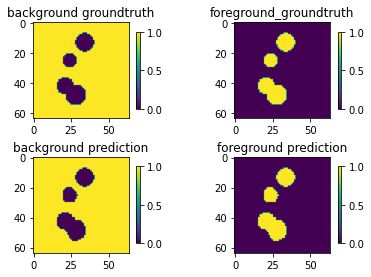

In [10]:
image_name = sim_datalist["testing"][0]["image"].split(".")[0]
prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name + "_ensemble" + ".nii.gz"))
pred = np.array(prediction_nib.dataobj)

img_slice32 = lbl[32] == 0
label_slice32 = lbl[32] == 1
background_slice32 = pred[32, :, :, 0] if pred.ndim == 4 else pred[32] == 0
foreground_slice32 = pred[32, :, :, 1] if pred.ndim == 4 else pred[32] == 1

plt.subplot(2, 2, 1)
plt.imshow(img_slice32)
plt.title("background groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 2)
plt.imshow(label_slice32)
plt.title("foreground_groundtruth")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 3)
plt.imshow(background_slice32)
plt.title("background prediction")
cbar = plt.colorbar(shrink=0.8)
plt.subplot(2, 2, 4)
plt.imshow(foreground_slice32)
plt.title("foreground prediction")
cbar = plt.colorbar(shrink=0.8)
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()